In [1]:
# Copyright (c) ContextualFairness contributors.
# Licensed under the MIT License.

# Binary classification

We consider a hypothetical loan approval scenario where a bank uses an ML model to predict applicants’ income. This notebook contains the binary classification variant of this scenario, where an individual's income is predicted to be either below or above 50000. We analyze the fairness analysis of this model with a baseline using equalized odds loss and with contextual fairness using different norms. We also show what happens when we apply a mitigation technique to the model.

This notebook matches the experiments for Binary classification in the paper *Assessing machine learning fairness with multiple contextual norms* (Section 4.1).

In [2]:
import sys

sys.path.append("../")

from folktables import ACSDataSource, ACSIncome

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib
import matplotlib.pyplot as plt

from fairlearn.preprocessing import CorrelationRemover

from contextualfairness.scorer import contextual_fairness_score
from contextualfairness.norms import BinaryClassificationEqualityNorm, RankNorm

import polars as pl


from _helper import group_plot

font = {"size": 18}
matplotlib.rc("font", **font)

### Load data 

Using the 2016 California ACS Income data

In [3]:
data_source = ACSDataSource(
    survey_year="2016", horizon="1-Year", survey="person", root_dir="data/raw"
)
acs_data_ca = data_source.get_data(states=["CA"], download="True")

### Prepare data and create train/test data

Sex is used as the sensitive attribute.

In [4]:
X, y, _ = ACSIncome.df_to_pandas(acs_data_ca)
y = y["PINCP"]
sensitive_attribute = X["SEX"].copy()

X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
    X, y, sensitive_attribute, test_size=0.2, random_state=0
)

### Train model

In [5]:
clf = LogisticRegression(max_iter=10_000, penalty="l2", random_state=42)
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


### Predictions for test data

In [6]:
y_pred = clf.predict(X_test)
y_pred_probas = clf.predict_proba(X_test)[:, 1]

### Equalized odds

The baseline is equalized odds. This states that the true positive and false postive rates should be the same across groups, in this case between males and females.
Therefore, equalized odds is achieved when the following equalities hold.

- $Pr(\hat{Y}=+50k|\text{sex}=\text{m} \land Y=+50k)=Pr(\hat{Y}=+50k|\text{sex}= \text{f} \land Y=+50k)$
- $Pr(\hat{Y}=+50k|\text{sex}=\text{m} \land Y=-50k)=Pr(\hat{Y}=+50k|\text{sex}=\text{f} \land Y=-50k)$

These equalities can be turned into a score by taking the absolute difference between the left and right-hand side of the equality.

In [7]:
male_true = len(X_test[(sens_test == 1.0) & y_test & y_pred]) / len(
    X_test[(sens_test == 1.0) & y_test]
)
male_false = len(X_test[(sens_test == 1.0) & ~y_test & y_pred]) / len(
    X_test[(sens_test == 1.0) & ~y_test]
)

female_true = len(X_test[(sens_test == 2.0) & y_test & y_pred]) / len(
    X_test[(sens_test == 2.0) & y_test]
)

female_false = len(X_test[(sens_test == 2.0) & ~y_test & y_pred]) / len(
    X_test[(sens_test == 2.0) & ~y_test]
)

### Plot results for equalized odds

<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
/var/folders/g1/5xrs_pf12bb3ptsyv9f6xgh00000gn/T/ipykernel_46251/3530362400.py:12: SyntaxWarning: invalid escape sequence '\h'
  ylabel="$Pr(\hat{Y}=Y_{pref}|g)$",


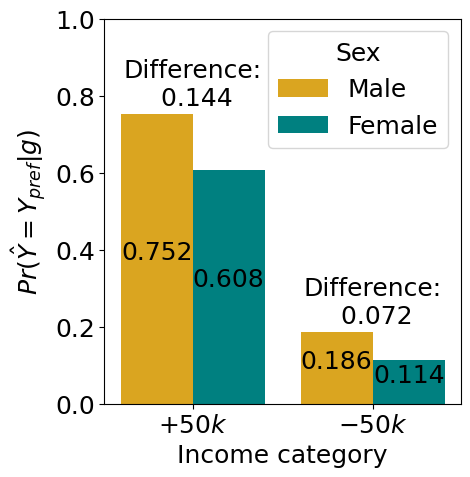

In [8]:
groups = [
    [male_true, male_false],  # male
    [female_true, female_false],  # female
]

group_plot(
    groups,
    legend=["Male", "Female"],
    legend_title="Sex",
    xticks=["$+50k$", "$-50k$"],
    xlabel="Income category",
    ylabel="$Pr(\hat{Y}=Y_{pref}|g)$",
    # title="Equalized odds",
    fig_width=4.6,
    fig_height=5,
    bar_width=0.4,
)

### Contextual fairness with equality norm

First, only the equality norm is considered for contextual fairness. That is, we assume that only the equality norm is relevant for the context.

In [9]:
norms = [BinaryClassificationEqualityNorm(positive_class_value=True)]

data = X_test.to_dict("list")
data["y_true"] = y_test

result = contextual_fairness_score(norms, data, y_pred, y_pred_probas)

In [10]:
total_score = result.total_score()
scaled_group_scores = result.group_scores(["SEX", "y_true"], scaled=True).collect()
unscaled_group_scores = result.group_scores(["SEX", "y_true"]).collect()

### Plot between-group scores

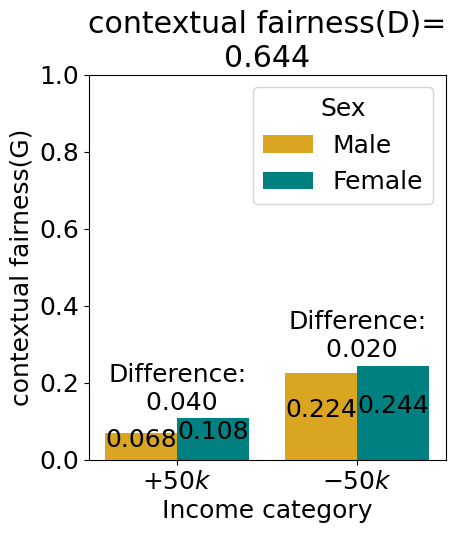

In [11]:
groups = [
    [
        scaled_group_scores.filter((pl.col("SEX") == 1.0) & pl.col("y_true"))
        .select("total")
        .item(),
        scaled_group_scores.filter((pl.col("SEX") == 1.0) & ~pl.col("y_true"))
        .select("total")
        .item(),
    ],
    [
        scaled_group_scores.filter((pl.col("SEX") == 2.0) & pl.col("y_true"))
        .select("total")
        .item(),
        scaled_group_scores.filter((pl.col("SEX") == 2.0) & ~pl.col("y_true"))
        .select("total")
        .item(),
    ],
]

group_plot(
    groups,
    legend=["Male", "Female"],
    legend_title="Sex",
    xticks=["$+50k$", "$-50k$"],
    xlabel="Income category",
    ylabel="contextual fairness(G)",
    title=f"contextual fairness(D)=\n{total_score:.3f}",
    fig_width=4.6,
    fig_height=5,
)

### Plot distribution of in-group scores

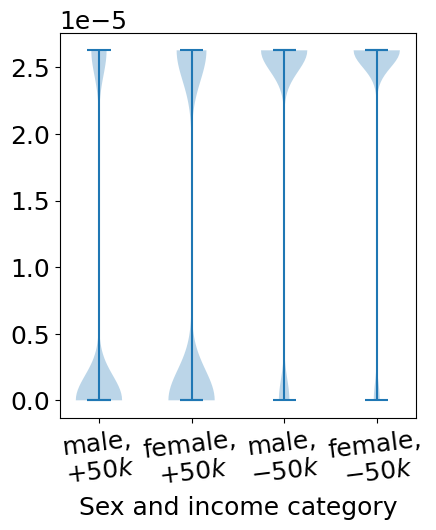

In [12]:
violin_data = [
    result.df.with_row_index()
    .filter(
        pl.col("index").is_in(
            unscaled_group_scores.filter((pl.col("SEX") == 1.0) & pl.col("y_true"))
            .select("indices")
            .item()
            .implode()
        )
    )
    .drop("index")
    .select("total")
    .collect()["total"]
    .to_list(),
    result.df.with_row_index()
    .filter(
        pl.col("index").is_in(
            unscaled_group_scores.filter((pl.col("SEX") == 2.0) & pl.col("y_true"))
            .select("indices")
            .item()
            .implode()
        )
    )
    .drop("index")
    .select("total")
    .collect()["total"]
    .to_list(),
    result.df.with_row_index()
    .filter(
        pl.col("index").is_in(
            unscaled_group_scores.filter((pl.col("SEX") == 1.0) & ~pl.col("y_true"))
            .select("indices")
            .item()
            .implode()
        )
    )
    .drop("index")
    .select("total")
    .collect()["total"]
    .to_list(),
    result.df.with_row_index()
    .filter(
        pl.col("index").is_in(
            unscaled_group_scores.filter((pl.col("SEX") == 2.0) & ~pl.col("y_true"))
            .select("indices")
            .item()
            .implode()
        )
    )
    .drop("index")
    .select("total")
    .collect()["total"]
    .to_list(),
]

fig, ax = plt.subplots(figsize=(4.6, 5))
ax.violinplot(violin_data, showmeans=False, showmedians=True)
ax.tick_params(axis="x", labelrotation=7)
ax.set_xticks(
    [y + 1 for y in range(len(violin_data))],
    labels=["male,\n$+50k$", "female,\n$+50k$", "male,\n$-50k$", "female,\n$-50k$"],
)
ax.set_xlabel("Sex and income category")
# ax.set_title("Distribution of contextual fairness within each group")

plt.show()

### Contextual fairness with multiple norms

We now assume a different context, where multiple norms are relevant:

- Everybody should get the same prediction.
- People who work more hours should earn more.
- People with a lower education level should earn more.

The norms are weighed equally.

In [13]:
norms = [
    BinaryClassificationEqualityNorm(positive_class_value=True),
    RankNorm(norm_statement=pl.col("WKHP"), name="work_more_hours"),
    RankNorm(norm_statement=-pl.col("SCHL"), name="lower_education"),
]


# Add y_true to X_test, so we can calculate scores for the same groups as for equalized odds.
data = X_test.to_dict("list")
data["y_true"] = y_test


result = contextual_fairness_score(norms, data, y_pred, y_pred_probas)

In [14]:
total_score = result.total_score()
scaled_group_scores = result.group_scores(["SEX", "y_true"], scaled=True).collect()
unscaled_group_scores = result.group_scores(["SEX", "y_true"]).collect()

### Plot between-group scores

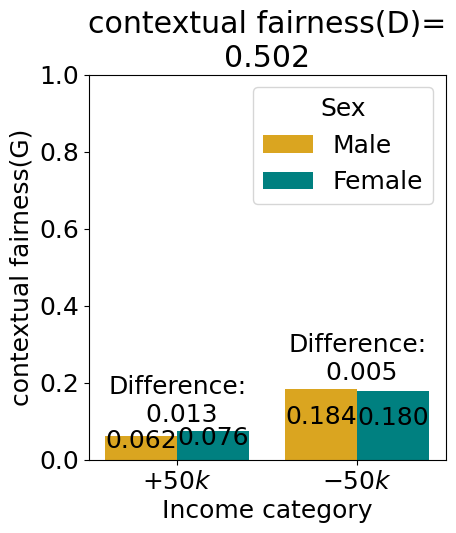

In [15]:
groups = [
    [
        scaled_group_scores.filter((pl.col("SEX") == 1.0) & pl.col("y_true"))
        .select("total")
        .item(),
        scaled_group_scores.filter((pl.col("SEX") == 1.0) & ~pl.col("y_true"))
        .select("total")
        .item(),
    ],
    [
        scaled_group_scores.filter((pl.col("SEX") == 2.0) & pl.col("y_true"))
        .select("total")
        .item(),
        scaled_group_scores.filter((pl.col("SEX") == 2.0) & ~pl.col("y_true"))
        .select("total")
        .item(),
    ],
]

group_plot(
    groups,
    legend=["Male", "Female"],
    legend_title="Sex",
    xticks=["$+50k$", "$-50k$"],
    xlabel="Income category",
    ylabel="contextual fairness(G)",
    title=f"contextual fairness(D)=\n{total_score:.3f}",
    fig_width=4.6,
    fig_height=5,
)

### Plot distribution of in-group scores

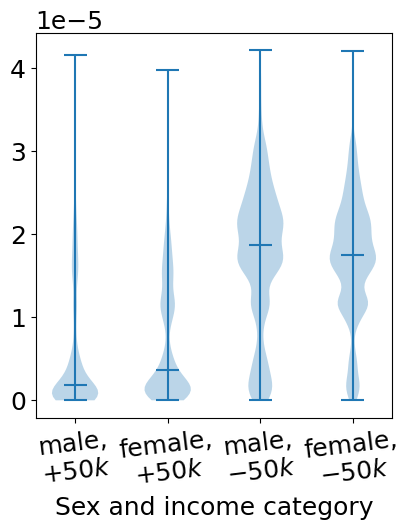

In [16]:
violin_data = [
    result.df.with_row_index()
    .filter(
        pl.col("index").is_in(
            unscaled_group_scores.filter((pl.col("SEX") == 1.0) & pl.col("y_true"))
            .select("indices")
            .item()
            .implode()
        )
    )
    .drop("index")
    .select("total")
    .collect()["total"]
    .to_list(),
    result.df.with_row_index()
    .filter(
        pl.col("index").is_in(
            unscaled_group_scores.filter((pl.col("SEX") == 2.0) & pl.col("y_true"))
            .select("indices")
            .item()
            .implode()
        )
    )
    .drop("index")
    .select("total")
    .collect()["total"]
    .to_list(),
    result.df.with_row_index()
    .filter(
        pl.col("index").is_in(
            unscaled_group_scores.filter((pl.col("SEX") == 1.0) & ~pl.col("y_true"))
            .select("indices")
            .item()
            .implode()
        )
    )
    .drop("index")
    .select("total")
    .collect()["total"]
    .to_list(),
    result.df.with_row_index()
    .filter(
        pl.col("index").is_in(
            unscaled_group_scores.filter((pl.col("SEX") == 2.0) & ~pl.col("y_true"))
            .select("indices")
            .item()
            .implode()
        )
    )
    .drop("index")
    .select("total")
    .collect()["total"]
    .to_list(),
]

fig, ax = plt.subplots(figsize=(4.6, 5))
ax.violinplot(violin_data, showmeans=False, showmedians=True)
ax.tick_params(axis="x", labelrotation=7)
ax.set_xticks(
    [y + 1 for y in range(len(violin_data))],
    labels=["male,\n$+50k$", "female,\n$+50k$", "male,\n$-50k$", "female,\n$-50k$"],
)
ax.set_xlabel("Sex and income category")
# ax.set_title("Distribution of contextual fairness within each group")

plt.show()

## Mitigate model

We now add a fairness mitigation technique in the model pipeline. We use FairLearn's correlation remover that removes the correlation between the sensitive attribute (i.e., sex) and the other attributes in the dataset. We then retrain the model on this mitigated dataset.

In [17]:
remover = CorrelationRemover(sensitive_feature_ids=["SEX"])
X_train = remover.fit_transform(X_train)

clf = LogisticRegression(max_iter=10_000, penalty="l2")
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [18]:
X_test_corr_removed = remover.transform(X_test)

y_pred = clf.predict(X_test_corr_removed)
y_pred_probas = clf.predict_proba(X_test_corr_removed)[:, 1]

### Equalized odds

We calculate equalized odds for the mitigated model.

In [19]:
male_true = len(X_test[(sens_test == 1.0) & y_test & y_pred]) / len(
    X_test[(sens_test == 1.0) & y_test]
)
male_false = len(X_test[(sens_test == 1.0) & ~y_test & y_pred]) / len(
    X_test[(sens_test == 1.0) & ~y_test]
)

female_true = len(X_test[(sens_test == 2.0) & y_test & y_pred]) / len(
    X_test[(sens_test == 2.0) & y_test]
)

female_false = len(X_test[(sens_test == 2.0) & ~y_test & y_pred]) / len(
    X_test[(sens_test == 2.0) & ~y_test]
)

### Plot results for equalized odds

<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
/var/folders/g1/5xrs_pf12bb3ptsyv9f6xgh00000gn/T/ipykernel_46251/401553272.py:12: SyntaxWarning: invalid escape sequence '\h'
  ylabel="$Pr(\hat{Y}=Y_{pref}|g)$",


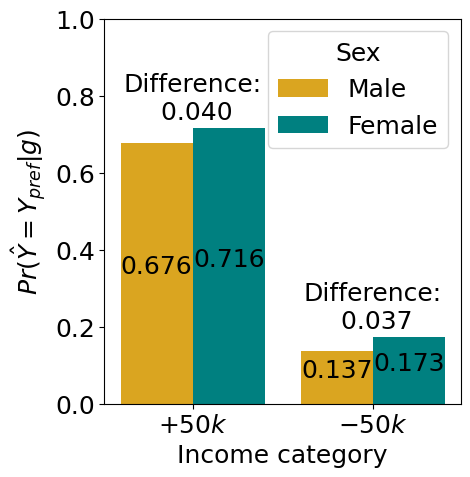

In [20]:
groups = [
    [male_true, male_false],  # male
    [female_true, female_false],  # female
]

group_plot(
    groups,
    legend=["Male", "Female"],
    legend_title="Sex",
    xticks=["$+50k$", "$-50k$"],
    xlabel="Income category",
    ylabel="$Pr(\hat{Y}=Y_{pref}|g)$",
    # title="Equalized odds",
    fig_width=4.6,
    fig_height=5,
)

### Contextual fairness

We use the same three norms as above to calculate contextual fairness for the mitigated model.

In [21]:
norms = [
    BinaryClassificationEqualityNorm(positive_class_value=True),
    RankNorm(norm_statement=pl.col("WKHP"), name="work_more_hours"),
    RankNorm(norm_statement=-pl.col("SCHL"), name="lower_education"),
]


# Add y_true to X_test, so we can calculate scores for the same groups as for equalized odds.
data = X_test.to_dict("list")
data["y_true"] = y_test


result = contextual_fairness_score(norms, data, y_pred, y_pred_probas)

In [22]:
total_score = result.total_score()
scaled_group_scores = result.group_scores(["SEX", "y_true"], scaled=True).collect()
unscaled_group_scores = result.group_scores(["SEX", "y_true"]).collect()

### Plot between-group scores

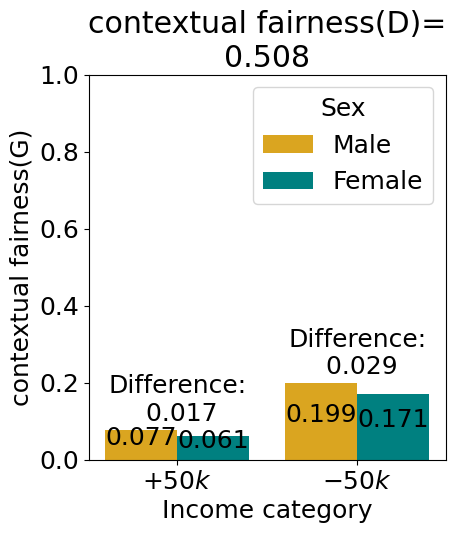

In [23]:
groups = [
    [
        scaled_group_scores.filter((pl.col("SEX") == 1.0) & pl.col("y_true"))
        .select("total")
        .item(),
        scaled_group_scores.filter((pl.col("SEX") == 1.0) & ~pl.col("y_true"))
        .select("total")
        .item(),
    ],
    [
        scaled_group_scores.filter((pl.col("SEX") == 2.0) & pl.col("y_true"))
        .select("total")
        .item(),
        scaled_group_scores.filter((pl.col("SEX") == 2.0) & ~pl.col("y_true"))
        .select("total")
        .item(),
    ],
]

group_plot(
    groups,
    legend=["Male", "Female"],
    legend_title="Sex",
    xticks=["$+50k$", "$-50k$"],
    xlabel="Income category",
    ylabel="contextual fairness(G)",
    title=f"contextual fairness(D)=\n{total_score:.3f}",
    fig_width=4.6,
    fig_height=5,
)

### Plot distribution of in-group scores

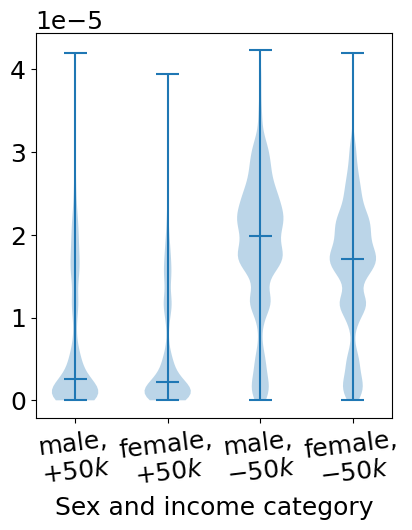

In [24]:
violin_data = [
    result.df.with_row_index()
    .filter(
        pl.col("index").is_in(
            unscaled_group_scores.filter((pl.col("SEX") == 1.0) & pl.col("y_true"))
            .select("indices")
            .item()
            .implode()
        )
    )
    .drop("index")
    .select("total")
    .collect()["total"]
    .to_list(),
    result.df.with_row_index()
    .filter(
        pl.col("index").is_in(
            unscaled_group_scores.filter((pl.col("SEX") == 2.0) & pl.col("y_true"))
            .select("indices")
            .item()
            .implode()
        )
    )
    .drop("index")
    .select("total")
    .collect()["total"]
    .to_list(),
    result.df.with_row_index()
    .filter(
        pl.col("index").is_in(
            unscaled_group_scores.filter((pl.col("SEX") == 1.0) & ~pl.col("y_true"))
            .select("indices")
            .item()
            .implode()
        )
    )
    .drop("index")
    .select("total")
    .collect()["total"]
    .to_list(),
    result.df.with_row_index()
    .filter(
        pl.col("index").is_in(
            unscaled_group_scores.filter((pl.col("SEX") == 2.0) & ~pl.col("y_true"))
            .select("indices")
            .item()
            .implode()
        )
    )
    .drop("index")
    .select("total")
    .collect()["total"]
    .to_list(),
]

fig, ax = plt.subplots(figsize=(4.6, 5))
ax.violinplot(violin_data, showmeans=False, showmedians=True)
ax.tick_params(axis="x", labelrotation=7)
ax.set_xticks(
    [y + 1 for y in range(len(violin_data))],
    labels=["male,\n$+50k$", "female,\n$+50k$", "male,\n$-50k$", "female,\n$-50k$"],
)
ax.set_xlabel("Sex and income category")
# ax.set_title("Distribution of contextual fairness within each group")

plt.show()